In [56]:
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False  # 步骤二（解决坐标轴负数的负号显示问题）
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

train_data = pd.read_csv('train_datasets.csv')
test_data  = pd.read_csv('test_datasets.csv')

In [57]:
test_data.head()

,母猪品种,variety,体况,body_condition,季节,season,胎次,配种前天数,配种后天数,产子后天数,产子数量,断奶后天数,饲料量
0,二元母猪,5,很胖,4,秋,2,4,NaN,NaN,28.0,4.0,NaN,4.311736
1,二元母猪,5,很瘦,0,秋,2,3,NaN,NaN,9.0,3.0,NaN,4.479014
2,苏太母猪,4,偏瘦,1,秋,2,4,1.0,NaN,NaN,NaN,NaN,3.850193
3,二元母猪,5,很瘦,0,春,0,4,8.0,NaN,NaN,NaN,NaN,3.300384
4,荣昌母猪,1,很胖,4,秋,2,6,NaN,NaN,NaN,NaN,6.0,3.206784


In [58]:
train_label = train_data['饲料量']
train = train_data[['variety', 'body_condition', 'season', '胎次', '配种前天数', '配种后天数', '产子后天数', '产子数量', '断奶后天数']]
test = test_data[['variety', 'body_condition', 'season', '胎次', '配种前天数', '配种后天数', '产子后天数', '产子数量', '断奶后天数']]
train = train.fillna(0)
test  = test.fillna(0)
data = pd.concat([train, test])
data = pd.get_dummies(data, columns=['variety', 'body_condition', 'season'])
train = data[:train.shape[0]]
test = data[train.shape[0]:]


param = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mse',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': 5,
    # 'max_depth': 3,
    'lambda_l2': 5, 'lambda_l1': 0
}
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2018)  # K-fold 交叉验证
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
evals_result = {}
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train_label)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(train.values[trn_idx],train_label.values[trn_idx],
#                            feature_name=list(train.columns),
#                           categorical_feature=li,
                           )
    
    val_data = lgb.Dataset(train.values[val_idx],train_label.values[val_idx],
#                         feature_name=list(train.columns),
#                           categorical_feature=li,
                           )

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],evals_result=evals_result,
#                     feature_name=list(train.columns),
#                           categorical_feature=li,
                    verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.values[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test.values, num_iteration=clf.best_iteration) / folds.n_splits

fold n°1
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.0878679	valid_1's l2: 0.0859571
[400]	training's l2: 0.0598596	valid_1's l2: 0.0588728
[600]	training's l2: 0.0572191	valid_1's l2: 0.0582108
Early stopping, best iteration is:
[508]	training's l2: 0.0579424	valid_1's l2: 0.058127
fold n°2
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.0873594	valid_1's l2: 0.0933994
[400]	training's l2: 0.0594939	valid_1's l2: 0.0623279
[600]	training's l2: 0.0567946	valid_1's l2: 0.0602125
Early stopping, best iteration is:
[659]	training's l2: 0.0564476	valid_1's l2: 0.0600733
fold n°3
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.0852345	valid_1's l2: 0.0915418
[400]	training's l2: 0.058116	valid_1's l2: 0.067446
[600]	training's l2: 0.0554705	valid_1's l2: 0.0666325
Early stopping, best iteration is:
[574]	training's l2: 0.0556106	valid_1's l2: 0.0665018
fold n°4
Training until v

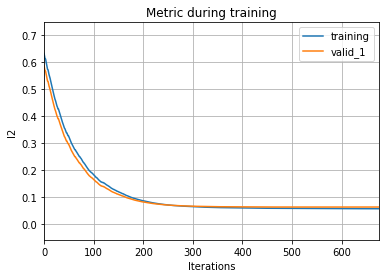

In [59]:
lgb.plot_metric(evals_result)

In [60]:
test['label'] = predictions_lgb

In [61]:
train_data.head()

,母猪品种,variety,体况,body_condition,季节,season,胎次,配种前天数,配种后天数,产子后天数,产子数量,断奶后天数,饲料量
0,荣昌母猪,1,偏胖,3,夏,1,2,NaN,4.0,NaN,NaN,NaN,2.253526
1,二元母猪,5,很胖,4,秋,2,4,NaN,NaN,20.0,4.0,NaN,4.393655
2,二元母猪,5,标准,2,春,0,3,6.0,NaN,NaN,NaN,NaN,3.246033
3,苏太母猪,4,很瘦,0,春,0,5,NaN,NaN,NaN,NaN,2.0,3.533572
4,太湖母猪,0,很瘦,0,春,0,1,NaN,6.0,NaN,NaN,NaN,3.212681


In [62]:
test_data["label"] = predictions_lgb

In [63]:
from sklearn.metrics import mean_squared_error
# MSE
mse_predict = mean_squared_error(test_data["label"], test_data['饲料量'])

In [64]:
mse_predict

0.059641739352377654